Reference: http://d.hatena.ne.jp/chrofieyue/20111202/1322832021

In [1]:
import os
import numpy as np
from scipy import arange, array, exp, eye, float64, log, maximum, ones, outer, pi, rand, zeros
from scipy.linalg import det, inv
from scipy.misc import logsumexp
from scipy.special import digamma

In [2]:
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

# Read Data

In [4]:
# read data
os.chdir(r"C:\Users\Shusei\Downloads")
data = np.genfromtxt("faithful.txt")
x = np.matrix(data[:, 0:2])
num, ndim = x.shape

x[:3] # show example

matrix([[  3.6  ,  79.   ],
        [  1.8  ,  54.   ],
        [  3.333,  74.   ]])

# Initialization

In [5]:
## initial value (Do we need it?)
num_class = 6; num_iter = 50; alpha0 = None; beta0 = None
m0 = None; W0 = None; nu0 = None

In [6]:
# Initialize Hyperparameters
alpha0 = np.matrix(ones(num_class) * 1e-3)
beta0 = 1e-3
m0 = np.matrix(zeros(ndim))
W0 = np.matrix(eye(2))
nu0 = 1
inv_W0 = np.matrix(inv(W0))

In [7]:
# Initialize Responsibility (VB-E Step)
r_nk = rand(num, num_class)
r_nk /= r_nk.sum(1)[:, None]

In [8]:
# 上の操作によってr_nkの行ごとに正規化しているみたい
r_nk.shape

(272, 6)

# VB-E-Step

## Dirichlet

In [9]:
# Expectation of Dirichlet
def expect_pi(alpha):
    return alpha / alpha.sum()

In [10]:
def expect_lpi(alpha):
    return digamma(alpha) - digamma(alpha.sum())

## Wishart

### slightly modified

In [11]:
def expect_llambda(W, nu):
    ndim = W.shape[0]
    arr = 0
    for index in range(ndim):
        i = index+1
        arr = digamma((nu + 1 - i)/2)
    
    return arr + ndim * log(2) + log(det(W))

In [12]:
def expect_lambda(W, nu):
    return W * nu

## Normal

#### [Caution] original modified

In [13]:
def expect_quad(x, m, beta, W, nu):
    ndim = x.shape[1]
    #return ndim / beta + nu * quad(W, x - m[None, :]) # original
    
    # m, W, beta, nuとかに来ているのは、mk[k]みたいなものなので注意
    temp = []
    for xrow in range(x.shape[0]):
        temp.append(ndim / beta + nu * (np.matrix((x[xrow] - m)[:, np.newaxis]) * np.matrix(W) * np.matrix((x[xrow] - m)[:, np.newaxis].transpose()))[0,0])
    return np.array(temp)

In [14]:
def expect_log(x, m, beta, W, nu): # log rhoの式かな Eq.(10.46)
    ndim = x.shape[1]

    ex_llambda = expect_llambda(W, nu)
    ex_quad = expect_quad(x, m, beta, W, nu)
    return (ex_llambda - ndim * log(2*pi) - ex_quad) / 2

## Normalization of Responsibility

In [15]:
def normalize_response(lrho):
    num, num_class = lrho.shape
    ret = zeros([num, num_class], dtype = float64)

    for i in range(num):
        lr = lrho[i] - logsumexp(lrho[i])
        ret[i] = exp(lr)

    ret = maximum(ret, 1e-10) # ゼロよけ
    ret /= ret.sum(1)[:, None]
    return ret

# VB-M-Step

#### アンチョコ p.94下の式

In [16]:
def calc_xbar(x, r_nk):
    num, ndim = x.shape
    num, num_class = r_nk.shape
    ret = zeros([num_class, ndim], dtype = float64)

    for k in range(num_class):
        clres = r_nk[:, k]
        for i in range(ndim):
            ret[k, i] = (clres * x[:, i]).sum()
        ret[k, :] /= clres.sum()

    return ret

In [17]:
def calc_S(x, xbar, r_nk): # this part is slightly modified
    num, ndim = x.shape
    num, num_class = r_nk.shape
    ret = zeros([num_class, ndim, ndim], dtype = float64)

    for k in range(num_class):
        clres = r_nk[:, k]
        temp = 0
        for i in range(ndim):
            diff_i = x[:, i] - xbar[k, i]
            temp = temp + clres[i] * ((diff_i) * diff_i.transpose()) 
        ret[k] = temp.sum() / clres.sum()
        
    return ret

#### アンチョコ p.95一番下のブロックの式の途中、平均

In [18]:
def calc_m(xbar, Nk, m0, beta0, beta):
    num_class, ndim = xbar.shape
    ret = zeros([num_class, ndim], dtype = float64)

    for k in range(num_class):
        ret[k] = (beta0 * m0 + Nk[k] * xbar[k]) / beta[k]

    return ret

#### アンチョコ p.96、精度

In [19]:
def calc_W(xbar, Sk, Nk, m0, beta0, inv_W0):
    num_class, ndim = xbar.shape
    ret = zeros([num_class, ndim, ndim], dtype = float64)

    for k in range(num_class):
        ret[k] = inv_W0 + Nk[k] * Sk[k]
        frac = beta0 * Nk[k] / (beta0 + Nk[k])
        diff = xbar[k] - m0 # here, it is a horizontal vector
        ret[k] = ret[k] + frac * (xbar[k] - m0).transpose() * (xbar[k] - m0)
        
        ret[k] = inv(ret[k])

    return ret

# 動かす

In [20]:
# # 一回分
# # VB-M Step (Dirichlet)
# Nk = r_nk.sum(0)
# alpha = alpha0 + Nk

# # VB-M Step (Normal-Wishart)
# xbar = calc_xbar(x, r_nk)
# Sk = calc_S(x, xbar, r_nk)
# beta = beta0 + Nk
# mk = calc_m(xbar, Nk, m0, beta0, beta)
# W = calc_W(xbar, Sk, Nk, m0, beta0, inv_W0)
# nu = nu0 + Nk

# # VB-E Step
# ex_lpi = expect_lpi(alpha)
# ex_log = zeros([num, num_class], dtype = float64)
# for k in range(num_class):
#     ex_log[:, k] = expect_log(x, mk[k], beta[k], W[k], nu[k])
# lrho = ex_lpi + ex_log
# r_nk = normalize_response(lrho)

In [21]:
for iiter in range(num_iter):
    # VB-M Step (Dirichlet)
    Nk = r_nk.sum(0)
    alpha = alpha0 + Nk

    # VB-M Step (Normal-Wishart)
    xbar = calc_xbar(x, r_nk)
    Sk = calc_S(x, xbar, r_nk)
    beta = beta0 + Nk
    mk = calc_m(xbar, Nk, m0, beta0, beta)
    W = calc_W(xbar, Sk, Nk, m0, beta0, inv_W0)
    nu = nu0 + Nk

    # VB-E Step
    ex_lpi = expect_lpi(alpha)
    ex_log = zeros([num, num_class], dtype = float64)
    for k in range(num_class):
        ex_log[:, k] = expect_log(x, mk[k], beta[k], W[k], nu[k])
    lrho = ex_lpi + ex_log
    r_nk = normalize_response(lrho)

# Visualization

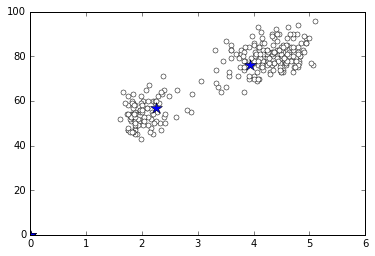

In [22]:
fp = open("faithful.txt")
data_x = []
data_y = []
for row in fp:
    data_x.append(float((row.split()[0])))
    data_y.append(float((row.split()[1])))
fp.close()
plt.plot(data_x, data_y, "wo", markersize=5)

for i in range(len(mk)):
    plt.plot(mk[i][0],mk[i][1], "*", markersize=12, color="b")